In [102]:
import numpy as np
import pandas as pd
import yaml
import matplotlib.pyplot as plt

# Import

First we open a file containing a dictionary of columns and associated data types generated in `../../optimize/`, then we read input file.

In [103]:
with open('../input/dtypes.yaml', 'r') as yamlfile:
    column_types = yaml.load(yamlfile)

read_csv_opts = {'sep': '|',
                 'quotechar': '"',
                 'compression': 'gzip',
                 'encoding': 'utf-8',
                 'dtype': column_types,
                 'parse_dates': ['MissionDate'],
                 'infer_datetime_format': True}

df = pd.read_csv('../input/ice-air.csv.gz', **read_csv_opts)

df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1763020 entries, 0 to 1763019
Data columns (total 44 columns):
Status                  category
Sex                     category
Convictions             category
GangMember              category
ClassLvl                float32
Age                     float32
MissionDate             datetime64[ns]
MissionNumber           uint32
PULOC                   category
DropLoc                 category
StrikeFromList          float32
ReasonStruck            category
R-T                     category
Code                    category
CountryOfCitizenship    category
Juvenile                bool
MissionWeek             uint8
MissionQuarter          uint8
MissionYear             uint16
MissionMonth            uint8
Criminality             category
FamilyUnitFlag          float32
UnaccompaniedFlag       float32
AlienMasterID           uint32
MissionID               uint16
air_AirportID           float32
air_AirportName         category
air_City         

In [104]:
with open('../input/airport_dict.yaml', 'r') as yamlfile:
    airport_dict = yaml.load(yamlfile)

# Airport report

For a given airport ICAO code represented in the ICE Air data, output a uniform set of variables, tables, and figures.

In [105]:
airport = 'KMSP'
if airport.upper() in airport_dict.keys():
    pass
else:
    print(f'{airport} not represented in dataset')
airport_name = airport_dict[airport]
pickup = df['PULOC'] == airport
dropoff = df['DropLoc'] == airport

pickup_df = df[pickup]
dropoff_df = df[dropoff]

pickup_df.set_index('MissionDate', inplace=True)
dropoff_df.set_index('MissionDate', inplace=True)

# pickup_df.to_csv(f'../output/{airport}_pickups.csv')
# dropoff_df.to_csv(f'../output/{airport}_dropoffs.csv')

all_df = pd.concat([pickup_df, dropoff_df]).drop_duplicates()

# This grouped table would work for mapping flights from specific airports.
all_missions = all_df.groupby(['MissionDate', 'MissionID', 'PULOC', 'DropLoc'])['AlienMasterID'].nunique()
# all_missions.to)csv(f'../output/{airport}_all_missions.csv')

In [106]:
weekly_pickups = pickup_df['AlienMasterID'].resample('W').nunique()
weekly_dropoffs = dropoff_df['AlienMasterID'].resample('W').nunique()
monthly_pickups = pickup_df['AlienMasterID'].resample('M').nunique()
monthly_dropoffs = dropoff_df['AlienMasterID'].resample('M').nunique()
monthly_pickup_flights = pickup_df['MissionID'].resample('M').nunique()
monthly_dropoff_flights = dropoff_df['MissionID'].resample('M').nunique()
annual_pickups = pickup_df['AlienMasterID'].resample('AS-OCT').nunique()
annual_dropoffs = dropoff_df['AlienMasterID'].resample('AS-OCT').nunique()
annual_pickup_flights = pickup_df['MissionID'].resample('AS-OCT').nunique()
annual_dropoff_flights = dropoff_df['MissionID'].resample('AS-OCT').nunique()

In [107]:
print(f'{airport} ({airport_name})')
print(f'---------------------------------------------------------')
unique_pickups = len(set(pickup_df['AlienMasterID']))
unique_dropoffs = len(set(dropoff_df['AlienMasterID']))
print(f'{unique_pickups} passengers picked up, {unique_dropoffs} passengers dropped off.')
print(f"{all_df['AlienMasterID'].nunique()} total unique passengers.")
print(f'{round(monthly_dropoffs.mean(), 2)} average dropoffs per month.')
print(f'{round(monthly_pickups.mean(), 2)} average pickups per month.')
print()
unique_pickup_flights = len(set(pickup_df['MissionID']))
unique_dropoff_flights = len(set(dropoff_df['MissionID']))
print(f'{unique_pickup_flights} pickup flights, {unique_dropoff_flights} dropoff flights.')
print(f"{all_df['MissionID'].nunique()} total missions.")
print(f'{round(monthly_dropoff_flights.mean(), 2)} average dropoff flights per month.')
print(f'{round(monthly_pickup_flights.mean(), 2)} average pickup flights per month.')

KMSP (Minneapolis-St Paul International/Wold-Chamberlain Airport)
---------------------------------------------------------
12158 passengers picked up, 655 passengers dropped off.
12813 total unique passengers.
6.68 average dropoffs per month.
122.81 average pickups per month.

301 pickup flights, 82 dropoff flights.
307 total missions.
0.84 average dropoff flights per month.
3.04 average pickup flights per month.


# Annual trends (by fiscal year)

In [108]:
annual_pickups.rename('Total pickups', inplace=True)
annual_pickups

MissionDate
2010-10-01    2505
2011-10-01    2070
2012-10-01    1638
2013-10-01    1241
2014-10-01     785
2015-10-01     770
2016-10-01    1248
2017-10-01    1592
2018-10-01     309
Freq: AS-OCT, Name: Total pickups, dtype: int64

In [109]:
annual_dropoffs.rename('Total dropoffs', inplace=True)
annual_dropoffs

MissionDate
2010-10-01     10
2011-10-01      4
2012-10-01     13
2013-10-01    267
2014-10-01     43
2015-10-01    130
2016-10-01     62
2017-10-01     48
2018-10-01     78
Freq: AS-OCT, Name: Total dropoffs, dtype: int64

In [110]:
annual_pickup_flights.rename('Total pickup flights', inplace=True)
annual_pickup_flights

MissionDate
2010-10-01    50
2011-10-01    51
2012-10-01    35
2013-10-01    32
2014-10-01    18
2015-10-01    25
2016-10-01    30
2017-10-01    49
2018-10-01    11
Freq: AS-OCT, Name: Total pickup flights, dtype: int64

In [111]:
annual_dropoff_flights.rename('Total dropoff flights', inplace=True)
annual_dropoff_flights

MissionDate
2010-10-01     5
2011-10-01     3
2012-10-01     8
2013-10-01    13
2014-10-01     6
2015-10-01     9
2016-10-01    15
2017-10-01    18
2018-10-01     5
Freq: AS-OCT, Name: Total dropoff flights, dtype: int64

In [112]:
annual_summary = pd.DataFrame({'Annual Pickups': annual_pickups,
              'Annual Pickup Flights': annual_pickup_flights,
              'Annual Dropoffs': annual_dropoffs,
             ' Annual Pickup Flights': annual_dropoff_flights,})

In [113]:
annual_summary.index = annual_summary.index.year+1 
annual_summary.index.name = 'FiscalYear'

In [114]:
annual_summary.to_csv(f'../output/{airport}_annual_summary.csv')

In [115]:
sum(annual_pickup_flights) + sum(annual_dropoff_flights)

383

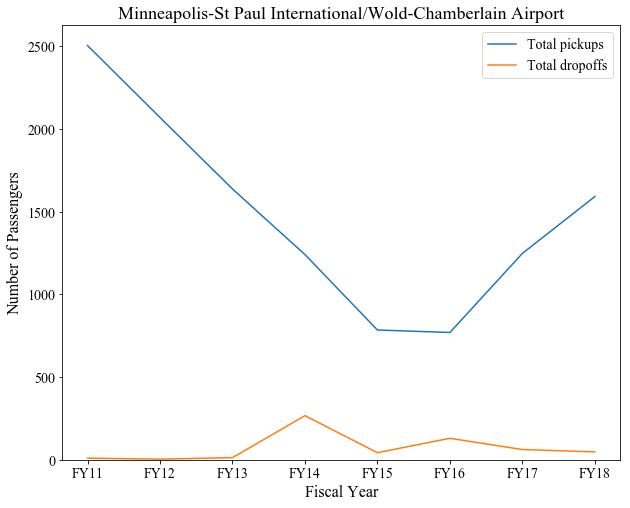

In [116]:
def pickup_dropoff_trend(data):
    
    fig, ax = plt.subplots()
    
    for datum in data:
        ax = datum.plot(legend=True)
    
    ax.set_ylabel('Number of Passengers', fontsize=16)
    ax.set_ylim(0)
    ax.set_xticklabels([f'FY{str(x)[2:4]}' for x in range(2010,2019)])
    ax.set_xlabel('Fiscal Year', fontsize=16)
    ax.set_title(f'{airport_name}', fontsize=18)
    ax.tick_params(labelsize=14)
    ax.legend(fontsize=14)
    
    fig.set_size_inches(10, 8)
    fig.savefig(f'../output/{airport}-ICE-Air-Passengers.png', dpi=100)
    return fig, ax

plot = pickup_dropoff_trend([annual_pickups['2010':'2017'], annual_dropoffs['2010':'2017']]);

# Annual pickup rate, by criminal conviction status

WARNING: Criminal conviction data is not consistently recorded by ICE, especially in FY 11.

In [117]:
annual_non_criminal = pickup_df[['NonCriminal']].resample('AS-OCT').sum()

In [118]:
annual_non_criminal['total'] = annual_pickups
annual_non_criminal['percent'] = annual_non_criminal['NonCriminal']/annual_pickups*100

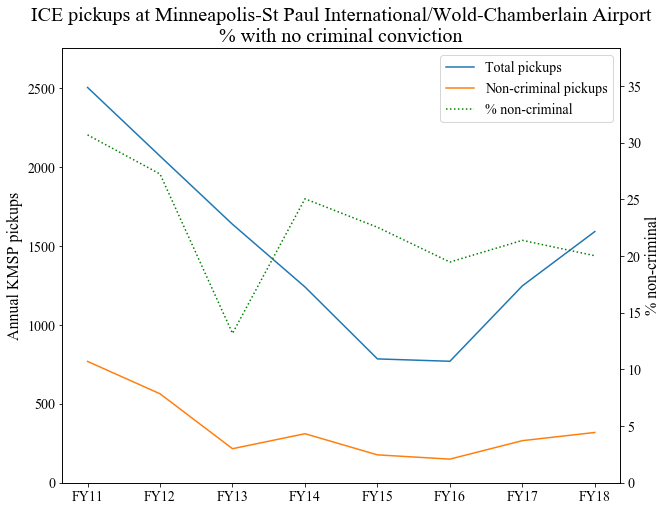

In [119]:
annual_data = annual_non_criminal['2010':'2017']
annual_data.index = [f'FY{str(x)[2:4]}' for x in range(2011,2019)]

plt.style.use([{'legend.frameon': True}])
plt.rc("font", family="Times New Roman")

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

lns1 = ax1.plot(annual_data['total'], label='Total pickups')
lns2 = ax1.plot(annual_data['NonCriminal'], label='Non-criminal pickups')
ax1_max = annual_data['total'].max()
ax1.set_ylim(0, (ax1_max * 1.1))
ax1.set_ylabel(f'Annual {airport} pickups', fontsize=16)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)

lns3 = ax2.plot(annual_data['percent'], label='% non-criminal', linestyle=':', color='green')
ax2_max = annual_data['percent'].max()
ax2.set_ylim(0, (ax2_max * 1.25))
ax2.set_ylabel('% non-criminal', fontsize=16)
ax2.tick_params(axis='y', labelsize=14)
# ax2.set_xticklabels([f'FY{str(x)[2:4]}' for x in range(2011,2019)])

lns = [lns1[0], lns2[0], lns3[0]]
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0, fontsize=14)

ax1.set_title(f'ICE pickups at {airport_name}\n% with no criminal conviction', fontsize=20)

fig.set_size_inches(10, 8)

plt.show()
fig.savefig(f'../output/{airport}_NoCrim.png', dpi=100)

# Monthly averages (by calendar year)

In [120]:
monthly_means = pd.DataFrame()
for year in range(2010, 2019):
    mean_pickups = monthly_pickups[f'{year}'].mean()
    mean_pickup_flights = monthly_pickup_flights[f'{year}'].mean()
    mean_dropoffs = monthly_dropoffs[f'{year}'].mean()
    mean_dropoff_flights = monthly_dropoff_flights[f'{year}'].mean()
    monthly_means = monthly_means.append({'calendar_year':year,
                                          'monthly_mean_pickups':mean_pickups,
                                          'monthly_mean_dropoffs':mean_dropoffs,
                                          'monthly_mean_pickup_flights':mean_pickup_flights,
                                          'monthly_mean_dropoff_flights':mean_dropoff_flights,
                                         }, ignore_index=True)
monthly_means['calendar_year'] = monthly_means['calendar_year'].astype(int)
monthly_means = monthly_means.set_index('calendar_year')

In [121]:
monthly_means.round(2)

,monthly_mean_dropoff_flights,monthly_mean_dropoffs,monthly_mean_pickup_flights,monthly_mean_pickups
calendar_year,,,,
2010,1.00,2.00,4.00,218.33
2011,0.25,0.50,4.25,201.42
2012,0.50,1.00,4.17,162.50
2013,0.67,0.75,2.67,124.67
2014,0.83,21.92,2.17,92.92
2015,0.58,8.00,1.75,63.25
2016,0.92,7.25,2.17,71.33
2017,1.33,5.75,2.83,115.25
2018,1.58,9.08,4.08,127.25


In [122]:
monthly_means.to_csv(f'../output/{airport}_monthly_means.csv')

# Top nationalities

In [123]:
pickup_df.drop_duplicates(subset='AlienMasterID')['CountryOfCitizenship'].value_counts().head(10)

MEXICO         8176
GUATEMALA      1480
HONDURAS        796
EL SALVADOR     736
ECUADOR         289
SOMALIA         186
NICARAGUA       116
LIBERIA          67
SOUTH SUDAN      39
CAMBODIA         33
Name: CountryOfCitizenship, dtype: int64

In [124]:
dropoff_df.drop_duplicates(subset='AlienMasterID')['CountryOfCitizenship'].value_counts().head(5)

EL SALVADOR    161
CHINA           47
SOMALIA         47
HONDURAS        45
MEXICO          44
Name: CountryOfCitizenship, dtype: int64

In [125]:
airport_all.drop_duplicates(subset='AlienMasterID')['CountryOfCitizenship'].value_counts().head(5)

MEXICO         27411
EL SALVADOR     6090
GUATEMALA       5920
HONDURAS        3809
INDIA           1543
Name: CountryOfCitizenship, dtype: int64

In [127]:
# airport_all.set_index('MissionDate', inplace=True)

# Chart of top nationalities per year

This chart shows the top five `CountryOfCitizenship` values for each fiscal year. It can be misleading because values are summed in "ALL OTHERS" for years in which a particular nationalitiy is not in the top 5, but it makes clear things like which years certain groups come into or leave the top 5.

Charts can be generated for pickups, dropoffs, or all records; this could also be reworked to focus on removal or transfer flights.

In [128]:
# Change groupby to `dropoff_df` to get table/figure of dropoff nationalities
# g = pickup_df.groupby(['PULOC', pd.Grouper(freq='AS-OCT', sort=True), 'CountryOfCitizenship'])['AlienMasterID', 'MissionID'].nunique()
g = airport_all.groupby([pd.Grouper(freq='AS-OCT', sort=True), 'CountryOfCitizenship'])['AlienMasterID', 'MissionID'].nunique()
country_of_citizenship_by_year = g.reset_index()
country_of_citizenship_by_year.rename({'MissionDate': 'FY'}, axis='columns', inplace=True)

# country_of_citizenship_by_year.to_csv(f'../output/{airport}_country_of_citizenship_by_year.csv', index=True)

In [129]:
country_of_citizenship_by_year.set_index('FY', inplace=True)

In [130]:
country_of_citizenship_by_year.sort_values(by='AlienMasterID', ascending=False, inplace=True)

In [131]:
top_5_df = pd.DataFrame()

for year in country_of_citizenship_by_year.index.unique():
    temp = country_of_citizenship_by_year.loc[f'{year}'][['CountryOfCitizenship', 'AlienMasterID']]
    temp_top_5 = temp[0:5]
    if len(temp) > 5:
        all_other_count = sum(temp['AlienMasterID'][5:])
    else:
        all_other_count = 0
    other_df = pd.DataFrame([['ALL OTHERS', all_other_count]], columns=['CountryOfCitizenship', 'AlienMasterID'], index=[year])
    temp_top_5 = temp_top_5.append(other_df)
    top_5_df = top_5_df.append(temp_top_5)

In [132]:
top_5_df.sort_index(inplace=True)
top_5_df.index = [f'FY{str(x)[2:4]}' for x in top_5_df.index.year + 1]

top_5_data = pd.pivot_table(data=top_5_df,
                       index=top_5_df.index,
                       columns='CountryOfCitizenship',
                       values='AlienMasterID',
                       aggfunc=np.sum,
                       fill_value=0)

top_5_data = top_5_data.reindex(pivot.sum().sort_values(ascending=False).index, axis=1)
cols = list(top_5_data.columns)
cols.remove('ALL OTHERS')
cols.append('ALL OTHERS')
top_5_data = top_5_data[cols]

top_5_data.columns = top_5_data.columns.str.title()
top_5_data.columns.name = 'Country of Citizenship'

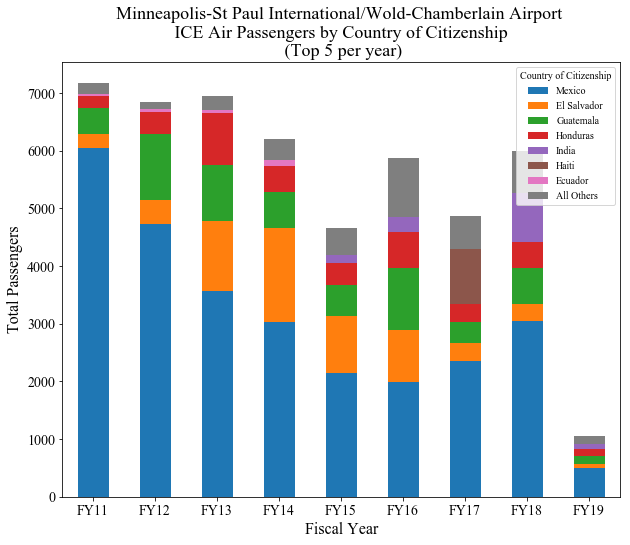

In [143]:
def country_of_citizenship_trend(data, title=str, filename=str, xlabel=str, ylabel=str):
    
    fig, ax = plt.subplots()
    
    data.plot(kind='bar', stacked=True, legend=True, ax=ax)

    ax.set_ylabel(ylabel, fontsize=16)
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_title(title, fontsize=18)
    ax.tick_params(labelsize=14)
    plt.xticks(rotation=0)

    fig.set_size_inches(10, 8)
    fig.savefig(f'../output/{filename}.png', dpi=100)
    return fig, ax

country_of_citizenship_trend(top_5_data,
                             title=f'{airport_name} \n ICE Air Passengers by Country of Citizenship \n (Top 5 per year)',
                             filename=f'{airport}_top5_nationalities',
                             ylabel='Total Passengers',
                             xlabel='Fiscal Year');

In [137]:
g = pickup_df.groupby(['PULOC', pd.Grouper(freq='AS-OCT', sort=True), 'air2_AirportName'])['AlienMasterID','MissionID'].nunique()
drop_locs_by_year = g.reset_index()
drop_locs_by_year.rename({'MissionDate': 'FY'}, axis='columns', inplace=True)

# drop_locs_by_year.to_csv(f'../output/{airport}_drop_locs_by_year.csv', index=True)

# Alternate plot of top nationalities

Since selecting top 5 for each year is a bit counterintuitive, we can instead select here an aribtrary set of nationalities to display for all years, while summing others. This can be based on most common values or could be some other arbitrary list. (See also implementation in `global.ipynb` for plotting all values that break top 5 for any year.)

Currently set up to focus on pickups but could be reworked for dropoffs, all passengers, or removals/transfers. Remember to update corresponding chart labels.

In [ ]:
annual = pickup_df.groupby([pd.Grouper(freq='AS-OCT', sort=True), 'CountryOfCitizenship'])['AlienMasterID'].nunique()
# annual = dropoff_df.groupby([pd.Grouper(freq='AS-OCT', sort=True), 'CountryOfCitizenship'])['AlienMasterID'].nunique()
# annual = airport_all.groupby([pd.Grouper(freq='AS-OCT', sort=True), 'CountryOfCitizenship'])['AlienMasterID'].nunique()

In [ ]:
annual = annual.reset_index()
annual.set_index('MissionDate', inplace=True)

In [ ]:
top6 = list(annual.groupby(['CountryOfCitizenship'])['AlienMasterID'].sum().sort_values(ascending=False).head(6).index)

top_6_df = pd.DataFrame()
top_6_df = top_6_df.append(annual[annual['CountryOfCitizenship'].isin(top6)])
top_6_df.index = top_6_df.index.year

for year in annual.index.year.unique():
    temp = annual[f'{year}']
    temp2 = temp[~temp['CountryOfCitizenship'].isin(top6)]
    all_other_count = temp2['AlienMasterID'].sum()
    other_df = pd.DataFrame([['ALL OTHERS', all_other_count]],
                            columns=['CountryOfCitizenship',
                                     'AlienMasterID'],
                            index=[year])
    top_6_df = top_6_df.append(other_df)

top_6_df.sort_index(inplace=True)
top_6_df.index = [f'FY{str(x)[2:4]}' for x in top_6_df.index + 1]

top_6_df['CountryOfCitizenship'] = top_6_df['CountryOfCitizenship'].astype('category')

top_6_data = pd.pivot_table(data=top_6_df,
                       index=top_6_df.index,
                       columns='CountryOfCitizenship',
                       values='AlienMasterID',
                       aggfunc=np.sum,
                       fill_value=0)
top_6_data = top_6_data.reindex(top_6_data.sum().sort_values(ascending=False).index, axis=1)
cols = list(top_6_data.columns)
cols.remove('ALL OTHERS')
cols.append('ALL OTHERS')
top_6_data = top_6_data[cols]

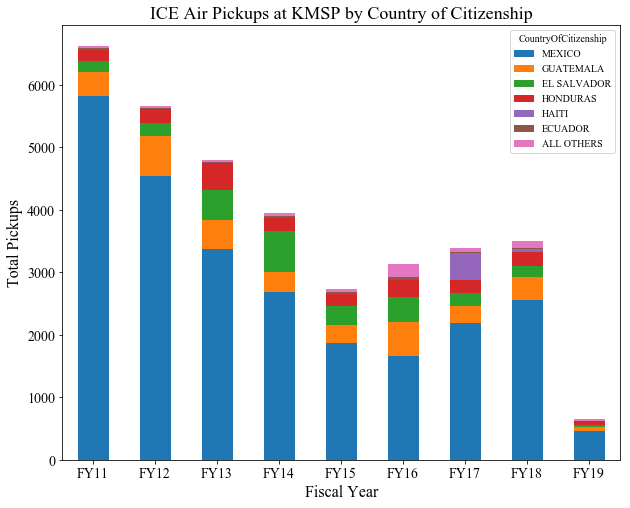

In [146]:
country_of_citizenship_trend(top_6_data,
                             title=f'ICE Air Pickups at {airport} by Country of Citizenship',
                             filename=f'{airport}_pickup_nationalities',
                             ylabel='Total Pickups',
                             xlabel='Fiscal Year');

# Juveniles (by fiscal year)

Table of just juveniles for pickups, dropoffs. Currently will fail if no juveniles.

In [ ]:
assert sum(airport_all['Juvenile']) > 0, f"No juveniles in dataset for {airport}"

In [ ]:
g = pickup_df.groupby(['PULOC', pd.Grouper(freq='AS-OCT', sort=True), 'Juvenile'])['AlienMasterID'].nunique()
juvenile_pickups = g.unstack()
juvenile_pickups['percent'] = juvenile_pickups[True] / juvenile_pickups[False] * 100
juvenile_pickups

In [ ]:
g = dropoff_df.groupby(['DropLoc', pd.Grouper(freq='AS-OCT', sort=True), 'Juvenile'])['AlienMasterID'].nunique()
juvenile_pickups = g.unstack()

In [ ]:
juvenile_pickups

In [ ]:
juvenile_pickups['percent'] = juvenile_pickups[True] / juvenile_pickups[False] * 100
juvenile_pickups